# 2. Create the total map for all frequencies by adding CMB realization, Synchrotron realization, and Noise realization together

In [19]:
# !pip install skyclean --upgrade  
import os
import healpy as hp
import skyclean as sc
# from skyclean import hp_alm_2_mw_alm, arcmin_to_radians, reduce_hp_map_resolution

In [28]:
# This function is not included in the Skyclean package because the storage directory and beam deconvolution process
#  are dependent on the user.

def create_and_save_total_map(frequency, realization, desired_lmax, directory="CMB_realizations"):
    """
    Processes the CMB, Synchrotron, and Noise maps for each frequency and realization, then combines them.

    Beam deconvolution is applied to the CMB map.
    The CMB, Synchrotron, and Noise maps are then reduced to the desired lmax.
    The reduced maps are then combined to create the total map.

    Parameters:
        frequency (str): frequency identifiers.
        realization (int): realization identifiers.
        desired_lmax (int): Maximum multipole moment for spherical harmonics.
        directory (str): Directory containing the input map files.
    """
    # Ensure the directory exists
    if not os.path.exists("CMB_total"):
        os.makedirs("CMB_total")

    print(f"Processing maps for frequency {frequency} and realization {realization}")
        
    # Define file paths
    CMB_file_path = f"{directory}/febecop_ffp10_lensed_scl_cmb_{frequency}_mc_{realization:04d}.fits"
    synchrotron_file_path = f"{directory}/COM_SimMap_synchrotron-ffp10-skyinbands-{frequency}_2048_R3.00_full.fits"
    noise_file_path = f"{directory}/ffp10_noise_{frequency}_full_map_mc_{realization:05d}.fits"
    
    # Read maps
    original_hp_CMB_map, cmb_header = hp.read_map(CMB_file_path, h = True)
    synchrotron, synchrotron_header = hp.read_map(synchrotron_file_path, h = True)
    noise, noise_header = hp.read_map(noise_file_path, h = True)

    # Remember to check the units of the maps by print(header) (CMB_K, MJy/sr, etc.)
    # The unit coversion: https://wiki.cosmos.esa.int/planckpla2015/index.php/UC_CC_Tables 
    # print(cmb_header)
    # print(synchrotron_header)
    # print(noise_header)
    
    if frequency == "545":
        unit_conversion = 58.0356
        original_hp_CMB_map = original_hp_CMB_map / unit_conversion
        synchrotron = synchrotron / unit_conversion
        noise =  noise / unit_conversion
    if frequency == "857":
        unit_conversion = 2.2681
        original_hp_CMB_map = original_hp_CMB_map / unit_conversion
        synchrotron = synchrotron / unit_conversion
        noise =  noise / unit_conversion

    # Define your own beam function path
    HFI_beam_path = "HFI_beams/"+ f"Bl_T_R3.01_fullsky_{frequency}x{frequency}.fits"
    
    beam_decon_cmb = sc.beam_deconvolution(original_hp_CMB_map, frequency, desired_lmax, sc.arcmin_to_radians(5), HFI_beam_path)
    
    
    # # Calculate nside based on lmax
    nside = desired_lmax // 2
            
        
    new_cmb,_ = sc.reduce_hp_map_resolution(beam_decon_cmb, desired_lmax, nside)
    new_synchrotron,_  = sc.reduce_hp_map_resolution(synchrotron, desired_lmax, nside)
    new_noise,_  = sc.reduce_hp_map_resolution(noise, desired_lmax, nside)
    
    # Save processed CMB map
    map_type = "CMB"    
    filename = f"CMB_total/{map_type}_HP_Map_F{frequency}_L{desired_lmax}_R{realization:04d}.fits"
    hp.write_map(filename, new_cmb,dtype="float64", overwrite=True)
    
        
    # Combine and save the total map 
    csn = new_cmb + new_synchrotron + new_noise

    # Save CSN map
    map_type = "CSN"    
    filename = f"CMB_total/{map_type}_HP_Map_F{frequency}_L{desired_lmax}_R{realization:04d}.fits"
    hp.write_map(filename, csn,dtype="float64", overwrite=True)
    print(f"Total Map for frequency {frequency} is saved to {filename}")


In [21]:
'''
import os
import numpy as np
import healpy as hp

# This function is not included in the Skyclean package because the storage directory and beam deconvolution process
# are dependent on the user.
def create_and_save_total_map(frequency, realization, desired_lmax, directory="CMB_realizations"):
    """
    Processes the CMB, Synchrotron, Noise, and tSZ maps for each frequency and realization, then combines them.

    Beam deconvolution is applied to the CMB map.
    The CMB, Synchrotron, Noise, and tSZ maps are then reduced to the desired lmax.
    The reduced maps are then combined to create the total map.
    """
    # Ensure the output directory exists
    os.makedirs("CMB_total", exist_ok=True)

    print(f"Processing maps for frequency {frequency} and realization {realization:04d}")

    # File paths (FFP10 simulation set + your downloaded tSZ sky-in-bands)
    CMB_file_path         = f"{directory}/febecop_ffp10_lensed_scl_cmb_{frequency}_mc_{realization:04d}.fits"
    synchrotron_file_path = f"{directory}/COM_SimMap_synchrotron-ffp10-skyinbands-{frequency}_2048_R3.00_full.fits"
    noise_file_path       = f"{directory}/ffp10_noise_{frequency}_full_map_mc_{realization:05d}.fits"
    # UPDATED: use your downloaded tSZ FFP10 sky-in-bands file (saved with 'tSZ_' prefix)
    tsz_file_path         = f"{directory}/tSZ_COM_SimMap_thermalsz-ffp10-skyinbands-{frequency}_2048_R3.00_full.fits"

    # Read maps (+ headers if needed)
    original_hp_CMB_map,  cmb_header         = hp.read_map(CMB_file_path, h=True)
    synchrotron,          synchrotron_header = hp.read_map(synchrotron_file_path, h=True)
    noise,                noise_header       = hp.read_map(noise_file_path, h=True)

    # Conditionally read tSZ map if available
    if os.path.exists(tsz_file_path):
        tsz_map = hp.read_map(tsz_file_path, verbose=False)
        include_tsz = True
    else:
        print(f"No tSZ map found for {frequency} GHz. Proceeding without it.")
        tsz_map = None
        include_tsz = False

    # -------- Unit handling (keep everything in K_CMB) --------
    # For 545/857 GHz, many FFP10 components are in MJy/sr. Convert them to K_CMB.
    # (Numbers are your existing factors: MJy/sr per K_CMB; so divide to get K_CMB.)
    if frequency == "545":
        unit_conversion = 58.0356
        original_hp_CMB_map /= unit_conversion
        synchrotron         /= unit_conversion
        noise               /= unit_conversion
        if include_tsz:
            tsz_map        /= unit_conversion  # NEW: convert tSZ too
    if frequency == "857":
        unit_conversion = 2.2681
        original_hp_CMB_map /= unit_conversion
        synchrotron         /= unit_conversion
        noise               /= unit_conversion
        if include_tsz:
            tsz_map         /= unit_conversion  # NEW: convert tSZ too

    # -------- Beam deconvolution for CMB (user-specific) --------
    # Define your own beam function path
    HFI_beam_path = "HFI_beams/" + f"Bl_T_R3.01_fullsky_{frequency}x{frequency}.fits"


    # sc.* comes from your Skyclean utilities (assumed available in your env)
    beam_decon_cmb = sc.beam_deconvolution(
        original_hp_CMB_map, frequency, desired_lmax, sc.arcmin_to_radians(5), HFI_beam_path)
    
    # -------- Synchrotron: remove pixel window + convolve with 5′ beam --------
    nside_sync = hp.get_nside(synchrotron)
    alm_sync = hp.map2alm(synchrotron, lmax=desired_lmax)
    pixwin_sync = hp.sphtfunc.pixwin(nside_sync, lmax=desired_lmax, pol=False)
    alm_sync = hp.almxfl(alm_sync, 1/pixwin_sync)   # remove pixel window
    alm_sync = hp.almxfl(alm_sync, Standard_bl)    # apply 5′ beam
    beam_conv_sync = hp.alm2map(alm_sync, nside=nside_sync)

        # -------- tSZ: remove pixel window + convolve with 5′ beam --------
    if include_tsz:
        nside_tsz = hp.get_nside(tsz_map)
        alm_tsz = hp.map2alm(tsz_map, lmax=desired_lmax)
        pixwin_tsz = hp.sphtfunc.pixwin(nside_tsz, lmax=desired_lmax, pol=False)
        alm_tsz = hp.almxfl(alm_tsz, 1/pixwin_tsz)   # remove pixel window
        alm_tsz = hp.almxfl(alm_tsz, Standard_bl)   # apply 5′ beam
        beam_conv_tsz = hp.alm2map(alm_tsz, nside=nside_tsz)
    else:
        beam_conv_tsz = np.zeros_like(beam_decon_cmb)
    
        # Choose NSIDE compatible with desired lmax (your reducer will handle exacts)
        nside = desired_lmax // 2

    # Reduce resolution / truncate to desired lmax
    new_cmb, _          = sc.reduce_hp_map_resolution(beam_decon_cmb,    desired_lmax, nside)
    new_synchrotron, _  = sc.reduce_hp_map_resolution(beam_conv_sync,    desired_lmax, nside)  # <-- use beam-conv
    new_noise, _        = sc.reduce_hp_map_resolution(noise,             desired_lmax, nside)
    if include_tsz:
        new_tsz, _      = sc.reduce_hp_map_resolution(beam_conv_tsz,     desired_lmax, nside)  # <-- use beam-conv
    else:
        new_tsz         = np.zeros_like(new_cmb)

    # Save components (including tSZ)
    hp.write_map(f"CMB_total/CMB_HP_Map_F{frequency}_L{desired_lmax}_R{realization:04d}.fits",
                 new_cmb, dtype="float64", overwrite=True)
    hp.write_map(f"CMB_total/Sync_HP_Map_F{frequency}_L{desired_lmax}_R{realization:04d}.fits",
                 new_synchrotron, dtype="float64", overwrite=True)
    hp.write_map(f"CMB_total/Noise_HP_Map_F{frequency}_L{desired_lmax}_R{realization:04d}.fits",
                 new_noise, dtype="float64", overwrite=True)
    hp.write_map(f"CMB_total/tSZ_HP_Map_F{frequency}_L{desired_lmax}_R{realization:04d}.fits",
                 new_tsz, dtype="float64", overwrite=True)

    # Combine all components
    csnt = new_cmb + new_synchrotron + new_noise + new_tsz
    hp.write_map(f"CMB_total/CSNT_HP_Map_F{frequency}_L{desired_lmax}_R{realization:04d}.fits",
                 csnt, dtype="float64", overwrite=True)

    print(f"✓ Total Map and components saved for {frequency} GHz, realization {realization:04d}")
'''

'\nimport os\nimport numpy as np\nimport healpy as hp\n\n# This function is not included in the Skyclean package because the storage directory and beam deconvolution process\n# are dependent on the user.\ndef create_and_save_total_map(frequency, realization, desired_lmax, directory="CMB_realizations"):\n    """\n    Processes the CMB, Synchrotron, Noise, and tSZ maps for each frequency and realization, then combines them.\n\n    Beam deconvolution is applied to the CMB map.\n    The CMB, Synchrotron, Noise, and tSZ maps are then reduced to the desired lmax.\n    The reduced maps are then combined to create the total map.\n    """\n    # Ensure the output directory exists\n    os.makedirs("CMB_total", exist_ok=True)\n\n    print(f"Processing maps for frequency {frequency} and realization {realization:04d}")\n\n    # File paths (FFP10 simulation set + your downloaded tSZ sky-in-bands)\n    CMB_file_path         = f"{directory}/febecop_ffp10_lensed_scl_cmb_{frequency}_mc_{realization:04d}

In [29]:
import numpy as np
import healpy as hp

def create_and_save_total_map(frequency, realization, desired_lmax, directory="CMB_realizations"):
    """
    Processes the CMB, Synchrotron, Noise, and tSZ maps for each frequency and realization, then combines them.
    """
    os.makedirs("CMB_total", exist_ok=True)

    print(f"Processing maps for frequency {frequency} and realization {realization:04d}")

    # File paths (FFP10 simulation set + your downloaded tSZ sky-in-bands)
    CMB_file_path         = f"{directory}/febecop_ffp10_lensed_scl_cmb_{frequency}_mc_{realization:04d}.fits"
    synchrotron_file_path = f"{directory}/COM_SimMap_synchrotron-ffp10-skyinbands-{frequency}_2048_R3.00_full.fits"
    noise_file_path       = f"{directory}/ffp10_noise_{frequency}_full_map_mc_{realization:05d}.fits"
    tsz_file_path         = f"{directory}/tSZ_COM_SimMap_thermalsz-ffp10-skyinbands-{frequency}_2048_R3.00_full.fits"

    # Read maps
    original_hp_CMB_map,  cmb_header         = hp.read_map(CMB_file_path, h=True)
    synchrotron,          synchrotron_header = hp.read_map(synchrotron_file_path, h=True)
    noise,                noise_header       = hp.read_map(noise_file_path, h=True)

    if os.path.exists(tsz_file_path):
        tsz_map = hp.read_map(tsz_file_path, verbose=False)
        include_tsz = True
    else:
        print(f"No tSZ map found for {frequency} GHz. Proceeding without it.")
        tsz_map = None
        include_tsz = False

    # -------- Unit handling --------
    if frequency == "545":
        unit_conversion = 58.0356
        original_hp_CMB_map /= unit_conversion
        synchrotron         /= unit_conversion
        noise               /= unit_conversion
        if include_tsz:
            tsz_map        /= unit_conversion
    if frequency == "857":
        unit_conversion = 2.2681
        original_hp_CMB_map /= unit_conversion
        synchrotron         /= unit_conversion
        noise               /= unit_conversion
        if include_tsz:
            tsz_map         /= unit_conversion

    # -------- Common 5′ beam --------
    Standard_bl = hp.sphtfunc.gauss_beam(sc.arcmin_to_radians(5), lmax=desired_lmax-1, pol=False)

    # -------- Beam deconvolution for CMB --------
    HFI_beam_path = "HFI_beams/" + f"Bl_T_R3.01_fullsky_{frequency}x{frequency}.fits"
    beam_decon_cmb = sc.beam_deconvolution(
        original_hp_CMB_map, frequency, desired_lmax, sc.arcmin_to_radians(5), HFI_beam_path)

    # -------- Synchrotron: remove pixwin + convolve with 5′ --------
    nside_sync   = hp.get_nside(synchrotron)
    alm_sync     = hp.map2alm(synchrotron, lmax=desired_lmax)
    pixwin_sync  = hp.sphtfunc.pixwin(nside_sync, lmax=desired_lmax, pol=False)
    alm_sync     = hp.almxfl(alm_sync, 1/pixwin_sync)   # remove pixwin
    alm_sync     = hp.almxfl(alm_sync, Standard_bl)     # apply 5′
    beam_conv_sync = hp.alm2map(alm_sync, nside=nside_sync)

    # -------- tSZ: remove pixwin + convolve with 5′ --------
    if include_tsz:
        nside_tsz  = hp.get_nside(tsz_map)
        alm_tsz    = hp.map2alm(tsz_map, lmax=desired_lmax)
        pixwin_tsz = hp.sphtfunc.pixwin(nside_tsz, lmax=desired_lmax, pol=False)
        alm_tsz    = hp.almxfl(alm_tsz, 1/pixwin_tsz)   # remove pixwin
        alm_tsz    = hp.almxfl(alm_tsz, Standard_bl)    # apply 5′
        beam_conv_tsz = hp.alm2map(alm_tsz, nside=nside_tsz)
    else:
        beam_conv_tsz = np.zeros_like(beam_decon_cmb)

    # -------- Reduce resolution --------
    nside = desired_lmax // 2
    new_cmb, _          = sc.reduce_hp_map_resolution(beam_decon_cmb,    desired_lmax, nside)
    new_synchrotron, _  = sc.reduce_hp_map_resolution(beam_conv_sync,    desired_lmax, nside)
    new_noise, _        = sc.reduce_hp_map_resolution(noise,             desired_lmax, nside)
    if include_tsz:
        new_tsz, _      = sc.reduce_hp_map_resolution(beam_conv_tsz,     desired_lmax, nside)
    else:
        new_tsz         = np.zeros_like(new_cmb)

    # -------- Save components --------
    hp.write_map(f"CMB_total/CMB_HP_Map_F{frequency}_L{desired_lmax}_R{realization:04d}.fits", new_cmb,        dtype="float64", overwrite=True)
    hp.write_map(f"CMB_total/Sync_HP_Map_F{frequency}_L{desired_lmax}_R{realization:04d}.fits", new_synchrotron, dtype="float64", overwrite=True)
    hp.write_map(f"CMB_total/Noise_HP_Map_F{frequency}_L{desired_lmax}_R{realization:04d}.fits", new_noise,      dtype="float64", overwrite=True)
    hp.write_map(f"CMB_total/tSZ_HP_Map_F{frequency}_L{desired_lmax}_R{realization:04d}.fits", new_tsz,        dtype="float64", overwrite=True)

    # -------- Combine all --------
    csnt = new_cmb + new_synchrotron + new_noise + new_tsz
    hp.write_map(f"CMB_total/CSNT_HP_Map_F{frequency}_L{desired_lmax}_R{realization:04d}.fits", csnt, dtype="float64", overwrite=True)

    csn = new_cmb + new_synchrotron + new_noise
    hp.write_map(f"CMB_total/CSN_HP_Map_F{frequency}_L{desired_lmax}_R{realization:04d}.fits", csn, dtype="float64", overwrite=True)

    print(f"✓ Total Map and components saved for {frequency} GHz, realization {realization:04d}")


# Reference: Skyclean functions to create total map

In [30]:
# Skyclean functions to create total map

import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
# import os
from astropy.io import fits #For beam deconvolution

def reduce_hp_map_resolution(hp_map, lmax, nside):
    """
    Processes a Healpix map by converting it to spherical harmonics and back,
    and reducing the resolution.
    
    Parameters:
        map_data (numpy.ndarray): Input map data.
        lmax (int): Maximum multipole moment for spherical harmonics.
        nside (int): Desired nside resolution for the output map.
        
    Returns:
        numpy.ndarray: Processed map data.
    """
    hp_alm = hp.map2alm(hp_map, lmax=lmax)
    processed_map = hp.alm2map(hp_alm, nside=nside)
    return processed_map, hp_alm


def beam_deconvolution(hp_map, frequency, lmax, standard_fwhm_rad, beam_path, LFI_beam_fwhm = {"030": 32.33, "044": 27.01, "070": 13.25}):
    """
    Performs beam deconvolution on the given CMB map data and returns the deconvolved map.

    Parameters:
        cmb_map (fits): CMB map data.
        frequency (str): Frequency identifier (e.g., "030", "044").
        lmax (int): Maximum multipole moment.
        standard_fwhm_rad (float): Standard beam full-width half-maximum in radians.
        beam_path (str): Path to the beam data file specific to the frequency.
        LFI_beam_fwhm (dict): Dictionary of beam full-width half-maximum (FWHM) in arcminutes for LFI frequencies.
    Returns:
      deconvolved_map (fits): The deconvolved CMB map.
    """
    nside = hp.get_nside(hp_map)
    cmb_alm = hp.map2alm(hp_map, lmax=lmax)
    
    # Standard beam for the desired FWHM
    Standard_bl = hp.sphtfunc.gauss_beam(standard_fwhm_rad, lmax=lmax-1, pol=False)
    
    # Pixel window function
    pixwin = hp.sphtfunc.pixwin(nside, lmax=lmax, pol=False)
    
    # LFI beam deconvolution
    if frequency in {"030", "044", "070"}:
        # Deconvolution for lower frequencies
        fwhm_rad = np.radians(LFI_beam_fwhm[frequency] / 60)
        bl = hp.sphtfunc.gauss_beam(fwhm_rad, lmax=lmax-1, pol=False)
        new_cmb_alm = hp.almxfl(cmb_alm, 1/bl)
    # HFI beam deconvolution
    else:
        # Deconvolution using FITS file for higher frequencies
        hfi = fits.open(beam_path)
        beam = hfi[1].data["TEMPERATURE"]
        new_cmb_alm = hp.almxfl(cmb_alm, 1/beam)
    
    # Apply pixel window function and standard beam
    new_cmb_alm = hp.almxfl(new_cmb_alm, 1/pixwin)
    new_cmb_alm = hp.almxfl(new_cmb_alm, Standard_bl)
    
    # Convert back to map
    deconvolved_map = hp.alm2map(new_cmb_alm, nside=nside)
    
    return deconvolved_map

In [31]:
frequencies = ["030", "044", "070", "100", "143", "217", "353", "545", "857"]
realizations = list(range(1))
desired_lmax = 64

for frequency in frequencies:
    for realization in realizations:
        all_maps_exist = all([
            os.path.exists(f"CMB_total/CMB_HP_Map_F{frequency}_L{desired_lmax}_R{realization:04d}.fits"),
            os.path.exists(f"CMB_total/Sync_HP_Map_F{frequency}_L{desired_lmax}_R{realization:04d}.fits"),
            os.path.exists(f"CMB_total/Noise_HP_Map_F{frequency}_L{desired_lmax}_R{realization:04d}.fits"),
            os.path.exists(f"CMB_total/CSNT_HP_Map_F{frequency}_L{desired_lmax}_R{realization:04d}.fits"),
            os.path.exists(f"CMB_total/CSN_HP_Map_F{frequency}_L{desired_lmax}_R{realization:04d}.fits")
            # Optional: include tSZ if you're using it
        ])
        
        if all_maps_exist:
            print(f"All component maps for {frequency} GHz, realization {realization:04d} exist. Skipping.")
            continue

        create_and_save_total_map(frequency, realization, desired_lmax, directory="CMB_realizations")

All component maps for 030 GHz, realization 0000 exist. Skipping.
All component maps for 044 GHz, realization 0000 exist. Skipping.
All component maps for 070 GHz, realization 0000 exist. Skipping.
All component maps for 100 GHz, realization 0000 exist. Skipping.
All component maps for 143 GHz, realization 0000 exist. Skipping.
All component maps for 217 GHz, realization 0000 exist. Skipping.
All component maps for 353 GHz, realization 0000 exist. Skipping.
All component maps for 545 GHz, realization 0000 exist. Skipping.
All component maps for 857 GHz, realization 0000 exist. Skipping.


## Cross-Correlatin Gain + Spectral Response

$$
k_\nu = \frac{\langle M_\nu(p)\, S(p) \rangle}{\langle S(p)^2 \rangle}
$$

- $S(p)$ = fixed spatial template of the component.  
- $M_\nu(p)$ = the map at frequency $\nu$.  
- $\langle \cdot \rangle$ = average over pixels (with mask).  

This is exactly the **cross-correlation slope** we coded.  
It avoids the cancellation issue of raw pixel averages.


Using L=64 (R=0000).


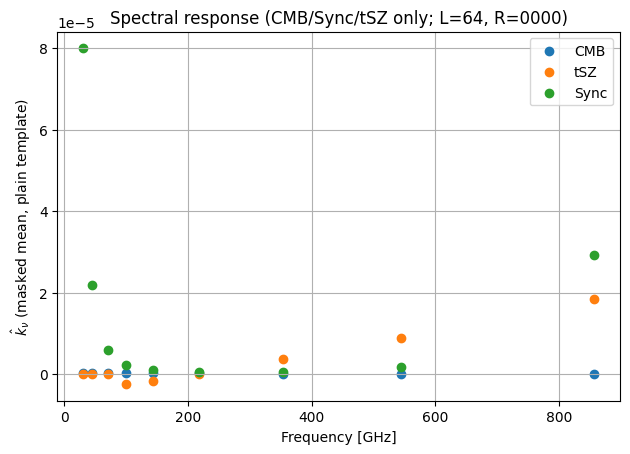

In [25]:
import os, glob, re
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

# ---------- config ----------
frequencies = ["030","044","070","100","143","217","353","545","857"]
freqs_ghz   = np.array([float(f) for f in frequencies])
realization = 0
realization_str = f"{realization:04d}"

# Only the components we care about (Noise ignored)
COMP_PREFIX = {
    "CMB":  "CMB_HP_Map",
    "Sync": "Sync_HP_Map",
    "tSZ":  "tSZ_HP_Map",
}
COLORS = {"CMB":"C0", "tSZ":"C1", "Sync":"C2"}

# optional mask file (1=keep, 0=exclude); leave "" to disable
mask_path = ""  # e.g. "masks/common_mask_n2048.fits"

# ---------- helpers ----------
def path_component_map(comp, freq, L, R4):
    return f"CMB_total/{COMP_PREFIX[comp]}_F{freq}_L{L}_R{R4}.fits"

def auto_detect_L(R4):
    patt = re.compile(r"_L(\d+)_R" + re.escape(R4) + r"\.fits$")
    counts = {}
    for pref in COMP_PREFIX.values():
        for f in frequencies:
            for p in glob.glob(f"CMB_total/{pref}_F{f}_L*_R{R4}.fits"):
                m = patt.search(p)
                if m:
                    L = int(m.group(1)); counts[L] = counts.get(L, 0) + 1
    return max(counts, key=counts.get) if counts else None

def read_hp(path, field=0):
    return hp.read_map(path, field=field, verbose=False)

def masked_mean(M, mask=None):
    if mask is not None:
        nside_m = hp.get_nside(M)
        mask_m = hp.ud_grade(mask, nside_out=nside_m, power=0) > 0
        good = mask_m & np.isfinite(M)
    else:
        good = np.isfinite(M)
    return np.nan if not np.any(good) else float(np.mean(M[good]))

# ---------- load mask (optional) ----------
mask = read_hp(mask_path) if mask_path else None

# ---------- determine L from saved files ----------
desired_lmax = auto_detect_L(realization_str)
if desired_lmax is None:
    raise FileNotFoundError("Could not auto-detect L from CMB_total filenames. "
                            "Make sure your component maps exist, or set desired_lmax manually.")
print(f"Using L={desired_lmax} (R={realization_str}).")

# ---------- compute k̂(ν) per component (Noise ignored) ----------
k_hat = {comp: np.full(len(frequencies), np.nan) for comp in COMP_PREFIX.keys()}

for comp in COMP_PREFIX.keys():
    for i, f in enumerate(frequencies):
        path = path_component_map(comp, f, desired_lmax, realization_str)
        if not os.path.exists(path):
            continue
        Mv = read_hp(path)
        k_hat[comp][i] = masked_mean(Mv, mask=mask)

# ---------- plot ----------
plt.figure()
for comp, color in COLORS.items():
    y = k_hat[comp]
    ok = np.isfinite(y)
    if ok.any():
        plt.scatter(freqs_ghz[ok], y[ok], label=comp, color=color)
plt.xlabel("Frequency [GHz]")
plt.ylabel(r"$\hat{k}_\nu$ (masked mean, plain template)")
plt.title(f"Spectral response (CMB/Sync/tSZ only; L={desired_lmax}, R={realization_str})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


✅ Spectral Response Matrix F:
[[ 1.00000000e+00 -1.95372099e+00  1.00000000e+00]
 [ 1.00000000e+00 -1.90097296e+00  3.16960932e-01]
 [ 1.00000000e+00 -1.75305173e+00  7.87172012e-02]
 [ 1.00000000e+00 -1.50826206e+00  2.70000000e-02]
 [ 1.00000000e+00 -1.04066552e+00  9.23327247e-03]
 [ 1.00000000e+00 -8.34822031e-03  2.64231483e-03]
 [ 1.00000000e+00  2.23969320e+00  6.13818040e-04]
 [ 1.00000000e+00  5.59637666e+00  1.66791632e-04]
 [ 1.00000000e+00  1.10880366e+01  4.28964446e-05]]

🔍 Linear Independence Check:
→ Rank of F: 3
→ Condition number of F: 15.49221201509465
→ Singular values: [13.1865341   2.93944617  0.85117181]


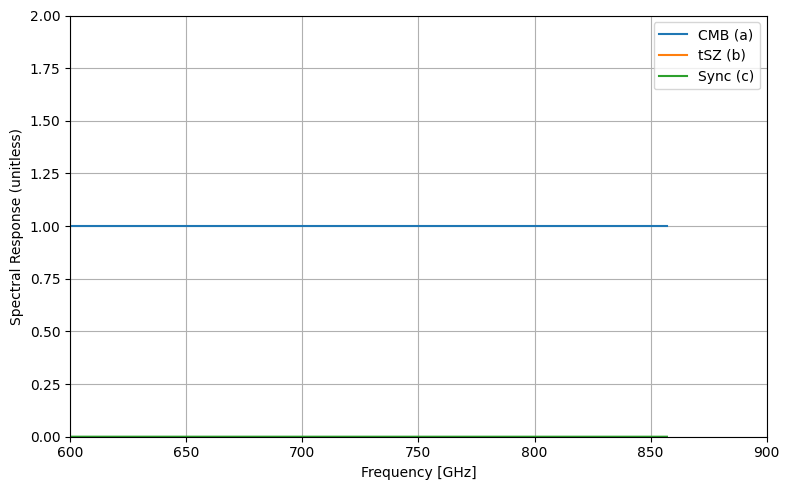

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import os

# --- Configuration ---
frequencies = ["030", "044", "070", "100", "143", "217", "353", "545", "857"]
frequencies_float = np.array([float(f) for f in frequencies])
components = ["CMB", "Sync", "Noise", "tSZ"]
realization = 0
desired_lmax = 64

pix_check = 100  # arbitrary pixel index to test the spectral mixing

# --- Define Spectral Response Vectors ---
a = np.ones(len(frequencies))  # CMB: flat in thermodynamic units

# tSZ: x = hν / kT_cmb ≈ ν / 56.8 GHz
x = frequencies_float / 56.8
b = x * (np.exp(x) + 1) / (np.exp(x) - 1) - 4  # tSZ thermal distortion shape

# Synchrotron: power-law with spectral index β ≈ -3.0
beta_sync = -3.0
c = (frequencies_float / 30.0)**beta_sync

# Stack into F
F = np.column_stack([a, b, c])
print("✅ Spectral Response Matrix F:")
print(F)

# --- Linear Independence Check ---
rank = np.linalg.matrix_rank(F)
cond = np.linalg.cond(F)
U, S, Vt = np.linalg.svd(F)

print("\n🔍 Linear Independence Check:")
print("→ Rank of F:", rank)
print("→ Condition number of F:", cond)
print("→ Singular values:", S)

# --- Plot Spectral Responses ---
plt.figure(figsize=(8, 5))
plt.plot(frequencies_float, a, label="CMB (a)")
plt.plot(frequencies_float, b, label="tSZ (b)")
plt.plot(frequencies_float, c, label="Sync (c)")
plt.xlim(600, 900)
plt.ylim(0,2)

plt.xlabel("Frequency [GHz]")
plt.ylabel("Spectral Response (unitless)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


CMB fit α = 1.1683550893426542e-07
tSZ fit α = 1.5488829761869266e-06
Sync fit α, β = [ 7.74924158e-05 -3.17511982e+00]


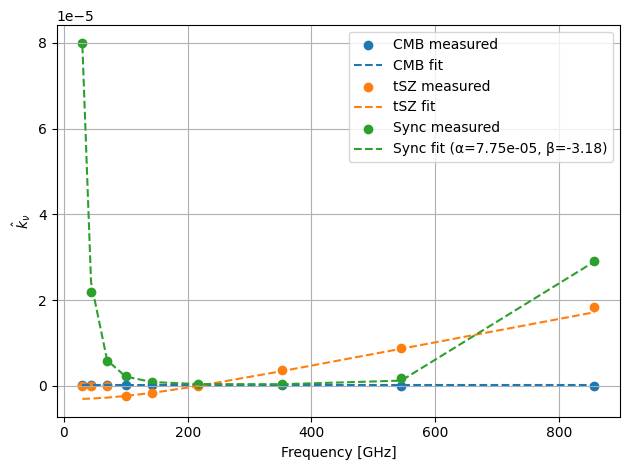

In [27]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

nu = freqs_ghz
y_CMB  = k_hat["CMB"]
y_tSZ  = k_hat["tSZ"]
y_Sync = k_hat["Sync"]

# --- theory models ---
def model_cmb(nu, alpha):
    return alpha * np.ones_like(nu)

def model_tsz(nu, alpha):
    x = nu / 56.8
    t = x * (np.exp(x)+1)/(np.exp(x)-1) - 4.0
    return alpha * t

def g_nu_func(nu):
    x = nu / 56.8
    return (x**2 * np.exp(x)) / (np.exp(x) - 1.0)**2

def model_sync(nu, alpha, beta):
    t = (nu/30.0)**beta / g_nu_func(nu)
    return alpha * t

# --- fits ---
ok = np.isfinite(y_CMB)
popt_cmb, _ = curve_fit(model_cmb, nu[ok], y_CMB[ok])

ok = np.isfinite(y_tSZ)
popt_tsz, _ = curve_fit(model_tsz, nu[ok], y_tSZ[ok])

ok = np.isfinite(y_Sync)
popt_sync, _ = curve_fit(model_sync, nu[ok], y_Sync[ok], p0=[1e-5, -3.0])

print("CMB fit α =", popt_cmb[0])
print("tSZ fit α =", popt_tsz[0])
print("Sync fit α, β =", popt_sync)

# --- plot ---
plt.figure()
plt.scatter(nu, y_CMB, color="C0", label="CMB measured")
plt.plot(nu, model_cmb(nu, *popt_cmb), "--", color="C0", label="CMB fit")

plt.scatter(nu, y_tSZ, color="C1", label="tSZ measured")
plt.plot(nu, model_tsz(nu, *popt_tsz), "--", color="C1", label="tSZ fit")

plt.scatter(nu, y_Sync, color="C2", label="Sync measured")
plt.plot(nu, model_sync(nu, *popt_sync), "--", color="C2", 
         label=f"Sync fit (α={popt_sync[0]:.2e}, β={popt_sync[1]:.2f})")

plt.xlabel("Frequency [GHz]")
plt.ylabel(r"$\hat{k}_\nu$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
